### Binary Classification Model for [PROJECT NAME] Using Python and Scikit-Learn version 15
### David Lowe
### September 15, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The data file patterns obtained by bouncing sonar signals off a metal cylinder or a rock at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.]

ANALYSIS: [Sample Paragraph - The average performance of the machine learning algorithms achieved an accuracy benchmark of 77.89%. Two algorithms (Extra Trees and Random Forest) produced the top accuracy metrics after the first round of modeling. After a series of tuning trials, the Random Forest model turned in an accuracy metric of 81.43%. When configured with the optimized parameters, the Random Forest model processed the validation dataset with an accuracy score of 85.71%. When we applied the Random Forest model to the previously unseen test dataset, we obtained an accuracy score of 69.04%.]

CONCLUSION: [Sample Paragraph - In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset. We should consider using the algorithm for further modeling.]

Dataset Used: [PROJECT NAME] Data Set

Dataset ML Model: Binary classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

One potential source of performance benchmark: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
attrNames = ['attr' + str(i).zfill(2) for i in range(1,61)]
colNames = attrNames + ['target']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
Xy_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R


In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

In [12]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [13]:
Xy_original.isnull().sum()

attr01    0
attr02    0
attr03    0
attr04    0
attr05    0
attr06    0
attr07    0
attr08    0
attr09    0
attr10    0
attr11    0
attr12    0
attr13    0
attr14    0
attr15    0
attr16    0
attr17    0
attr18    0
attr19    0
attr20    0
attr21    0
attr22    0
attr23    0
attr24    0
attr25    0
attr26    0
attr27    0
attr28    0
attr29    0
attr30    0
attr31    0
attr32    0
attr33    0
attr34    0
attr35    0
attr36    0
attr37    0
attr38    0
attr39    0
attr40    0
attr41    0
attr42    0
attr43    0
attr44    0
attr45    0
attr46    0
attr47    0
attr48    0
attr49    0
attr50    0
attr51    0
attr52    0
attr53    0
attr54    0
attr55    0
attr56    0
attr57    0
attr58    0
attr59    0
attr60    0
target    0
dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['col_name'].fillna(value=Xy_original['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with R/M levels into categorical feature of 0/1
def reclass_somecol(target):
    if target == 'M': return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['target'].apply(reclass_somecol)
Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,targetVar
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,0
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,0
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,0
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,0
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,0


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   attr01     208 non-null    float64
 1   attr02     208 non-null    float64
 2   attr03     208 non-null    float64
 3   attr04     208 non-null    float64
 4   attr05     208 non-null    float64
 5   attr06     208 non-null    float64
 6   attr07     208 non-null    float64
 7   attr08     208 non-null    float64
 8   attr09     208 non-null    float64
 9   attr10     208 non-null    float64
 10  attr11     208 non-null    float64
 11  attr12     208 non-null    float64
 12  attr13     208 non-null    float64
 13  attr14     208 non-null    float64
 14  attr15     208 non-null    float64
 15  attr16     208 non-null    float64
 16  attr17     208 non-null    float64
 17  attr18     208 non-null    float64
 18  attr19     208 non-null    float64
 19  attr20     208 non-null    float64
 20  attr21    

In [17]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,targetVar
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507,0.533654
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031,0.500070
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600,0.000000
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100,0.000000
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300,1.000000
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525,1.000000
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900,1.000000


In [18]:
Xy_original.isnull().sum()

attr01       0
attr02       0
attr03       0
attr04       0
attr05       0
attr06       0
attr07       0
attr08       0
attr09       0
attr10       0
attr11       0
attr12       0
attr13       0
attr14       0
attr15       0
attr16       0
attr17       0
attr18       0
attr19       0
attr20       0
attr21       0
attr22       0
attr23       0
attr24       0
attr25       0
attr26       0
attr27       0
attr28       0
attr29       0
attr30       0
attr31       0
attr32       0
attr33       0
attr34       0
attr35       0
attr36       0
attr37       0
attr38       0
attr39       0
attr40       0
attr41       0
attr42       0
attr43       0
attr44       0
attr45       0
attr46       0
attr47       0
attr48       0
attr49       0
attr50       0
attr51       0
attr52       0
attr53       0
attr54       0
attr55       0
attr56       0
attr57       0
attr58       0
attr59       0
attr60       0
targetVar    0
dtype: int64

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (208, 61) X_original.shape: (208, 60) y_original.shape: (208,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
X_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0195,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0052,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0061,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0118,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040


#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

#### 2.a.iii) Statistical summary of the attributes

In [27]:
X_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


#### 2.a.iv) Summarize the levels of the class attribute

In [28]:
Xy_original.groupby('targetVar').size()

targetVar
0     97
1    111
dtype: int64

### 2.b) Data Visualization

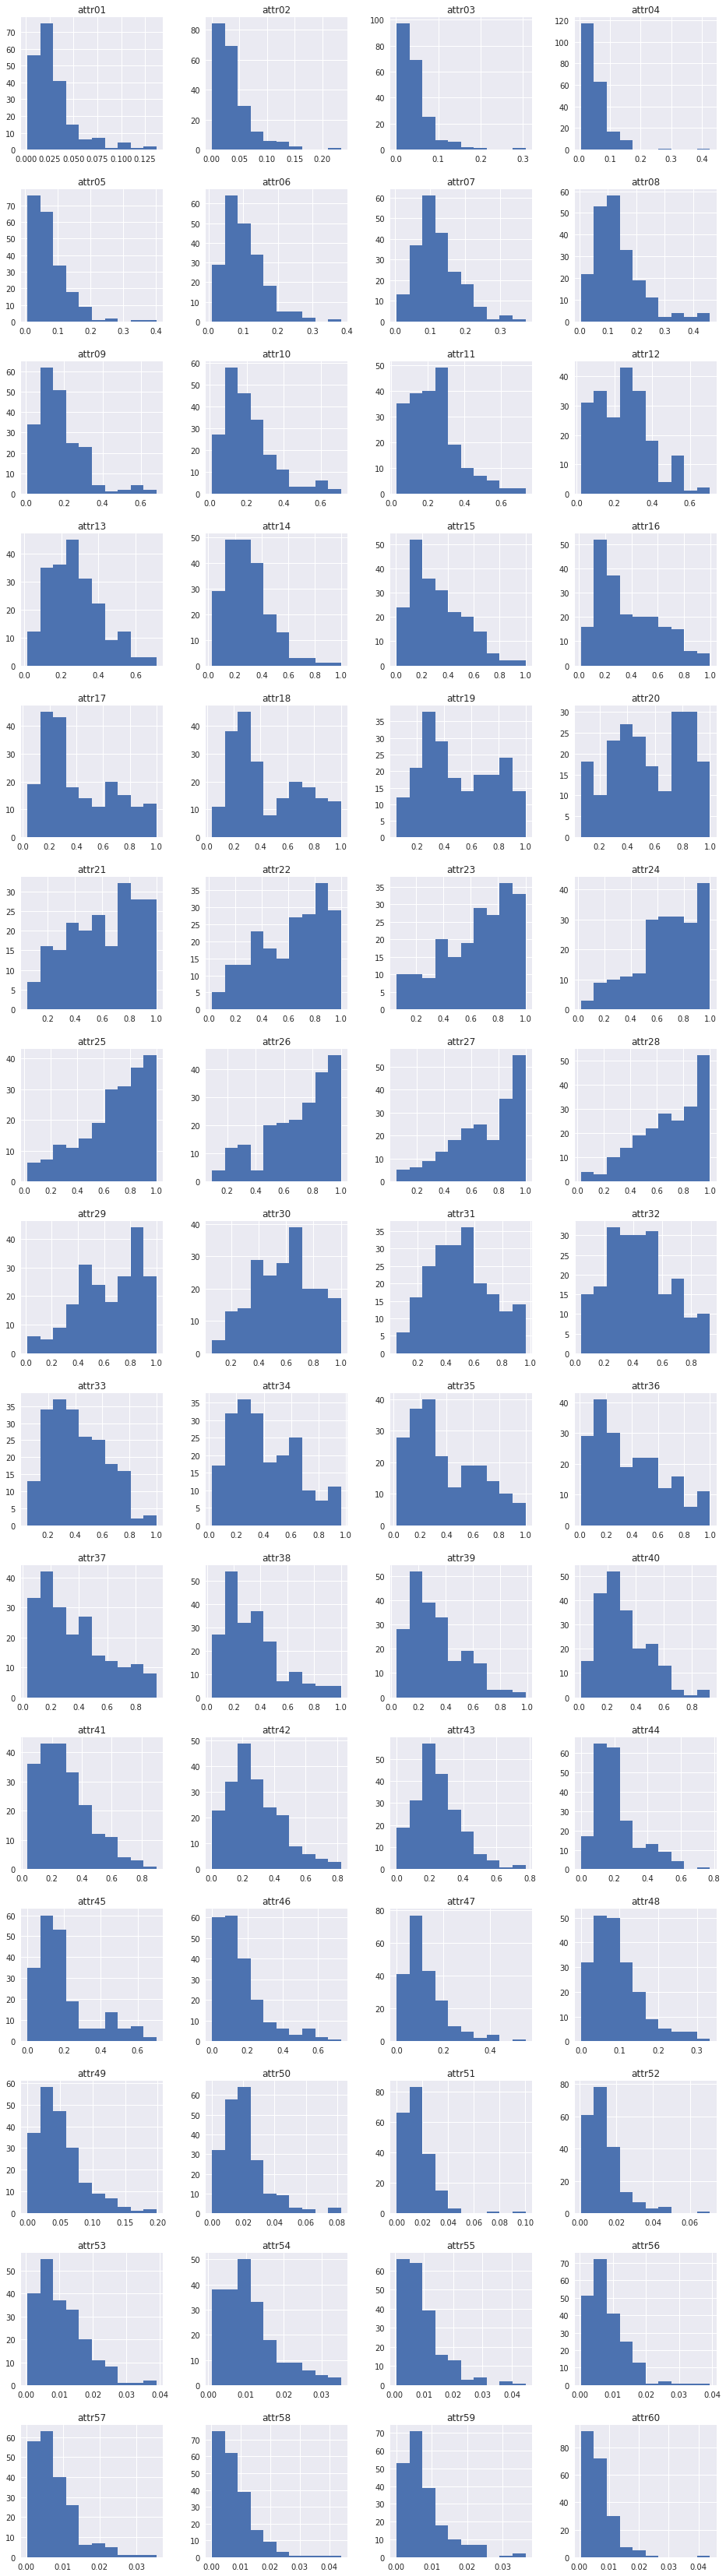

In [29]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

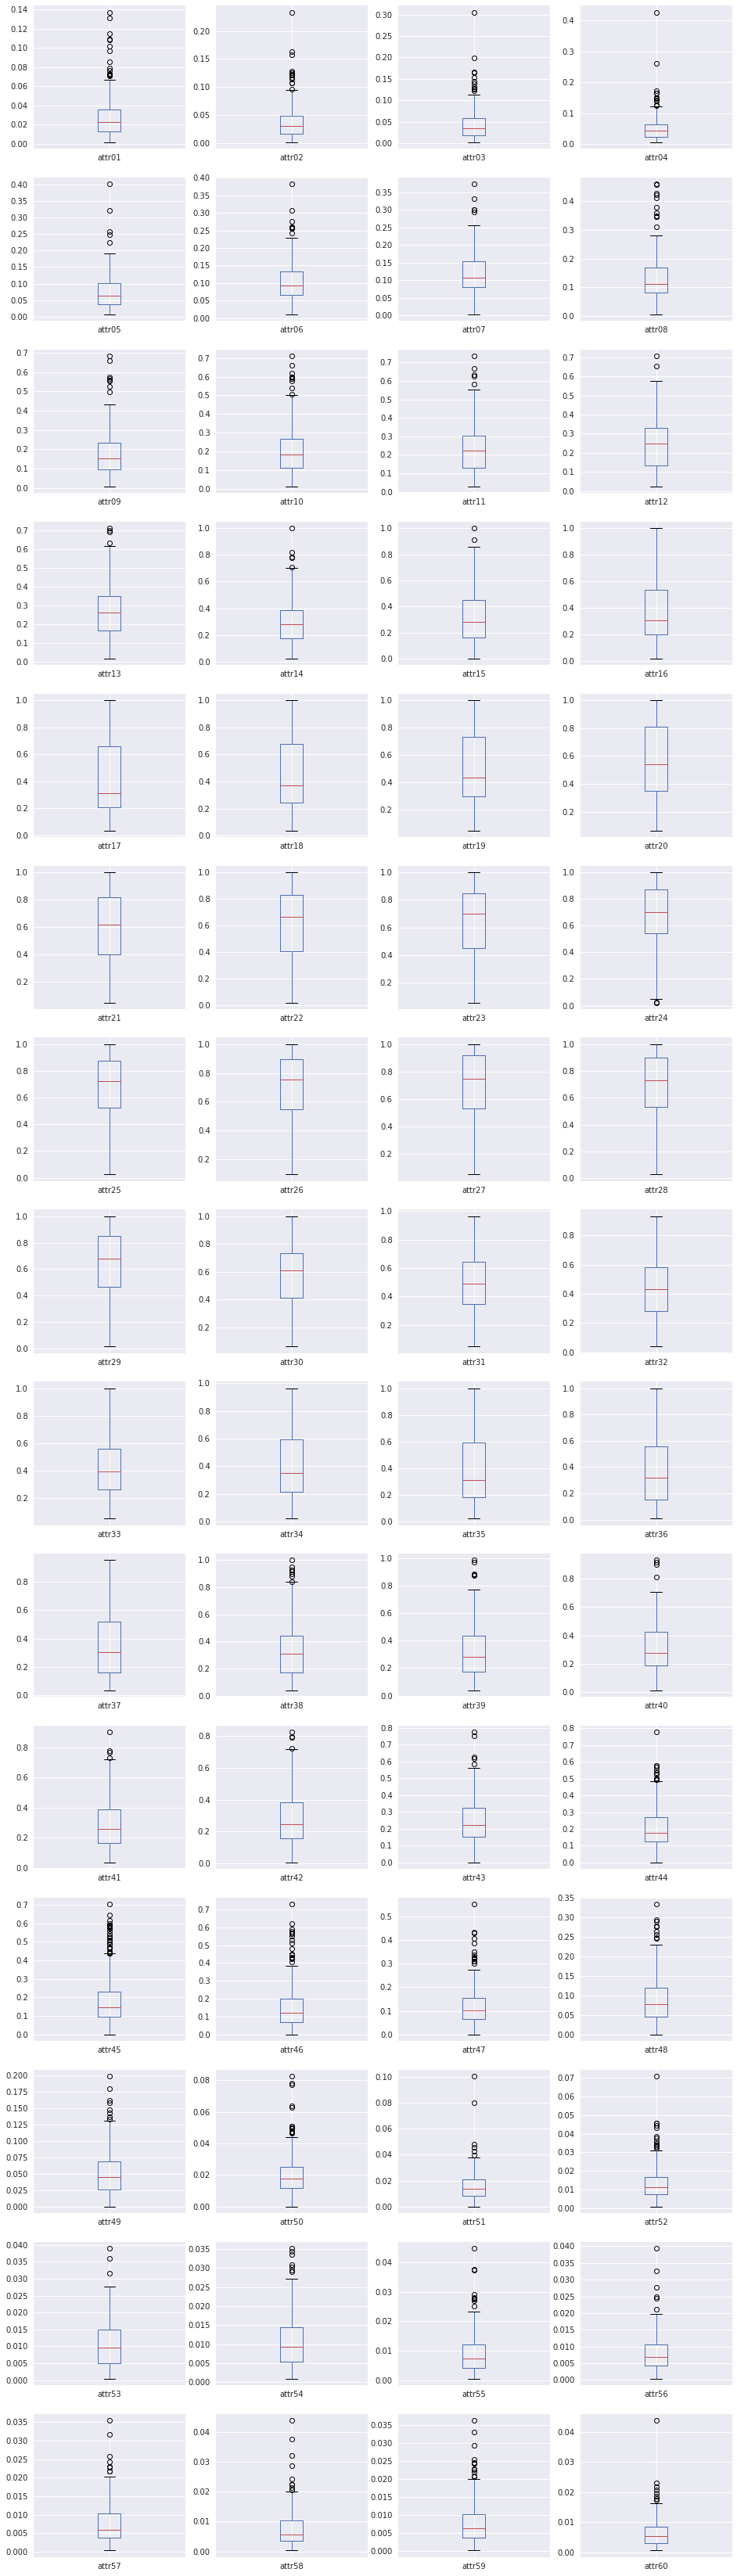

In [30]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

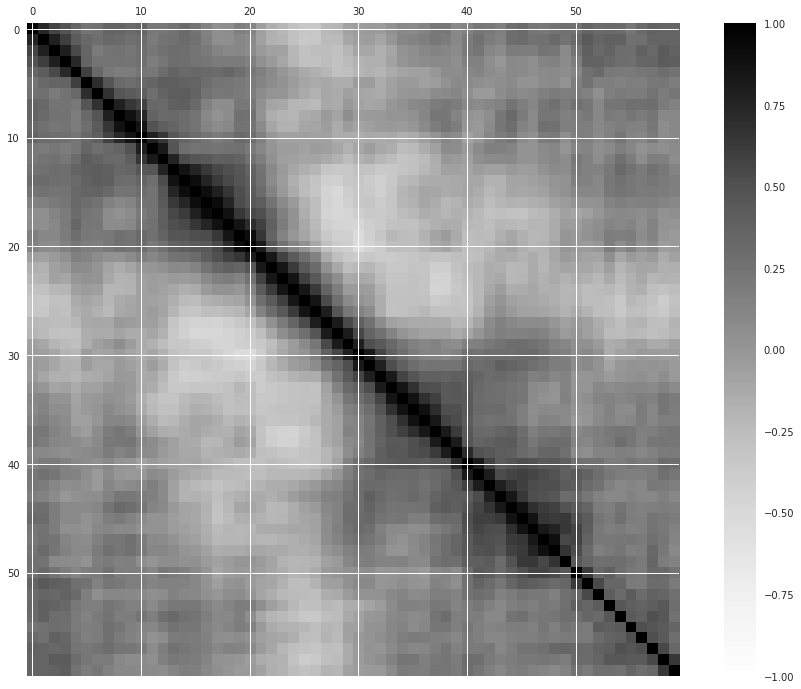

In [31]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [32]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [34]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [35]:
# Split the data further into training, validation, and test datasets
X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, stratify=y_train_val, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (124, 60) y_train_df.shape: (124,)
X_validation_df.shape: (42, 60) y_validation_df.shape: (42,)
X_test_df.shape: (42, 60) y_test_df.shape: (42,)


### 3.b) Feature Scaling and Data Pre-Processing

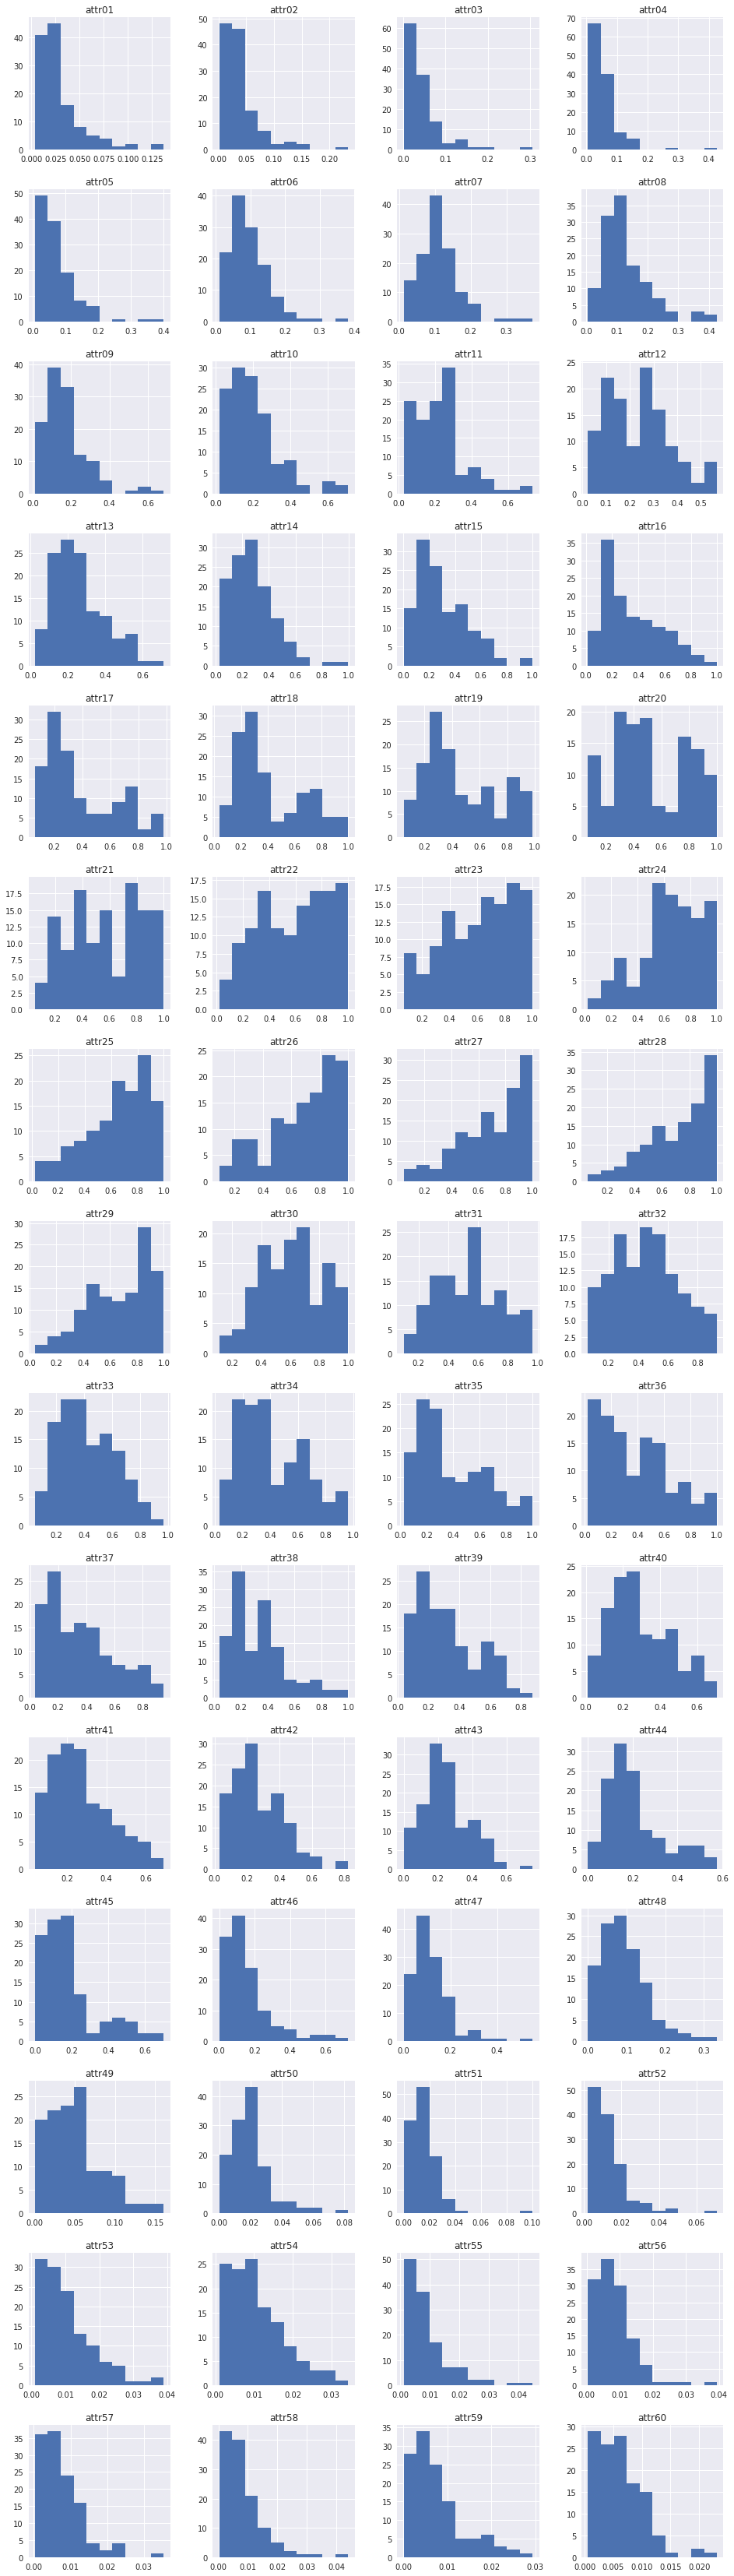

In [36]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'float64'].tolist()
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [37]:
# Apply feature scaling and transformation
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
print(X_train_df.head())

Columns to scale are: ['attr01', 'attr02', 'attr03', 'attr04', 'attr05', 'attr06', 'attr07', 'attr08', 'attr09', 'attr10', 'attr11', 'attr12', 'attr13', 'attr14', 'attr15', 'attr16', 'attr17', 'attr18', 'attr19', 'attr20', 'attr21', 'attr22', 'attr23', 'attr24', 'attr25', 'attr26', 'attr27', 'attr28', 'attr29', 'attr30', 'attr31', 'attr32', 'attr33', 'attr34', 'attr35', 'attr36', 'attr37', 'attr38', 'attr39', 'attr40', 'attr41', 'attr42', 'attr43', 'attr44', 'attr45', 'attr46', 'attr47', 'attr48', 'attr49', 'attr50', 'attr51', 'attr52', 'attr53', 'attr54', 'attr55', 'attr56', 'attr57', 'attr58', 'attr59', 'attr60']
       attr01    attr02    attr03    attr04    attr05    attr06    attr07    attr08    attr09    attr10  ...    attr51    attr52  \
114 -0.734347 -0.509241 -0.412821 -0.333397  0.832870  1.887527  0.671976 -0.440094 -0.326709 -0.161567  ...  0.509260  1.395114   
179  0.417101  0.049897  0.004007 -0.013872 -0.219787  0.765602 -0.267528 -0.600406 -0.092768  0.403209  ... -0.3

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

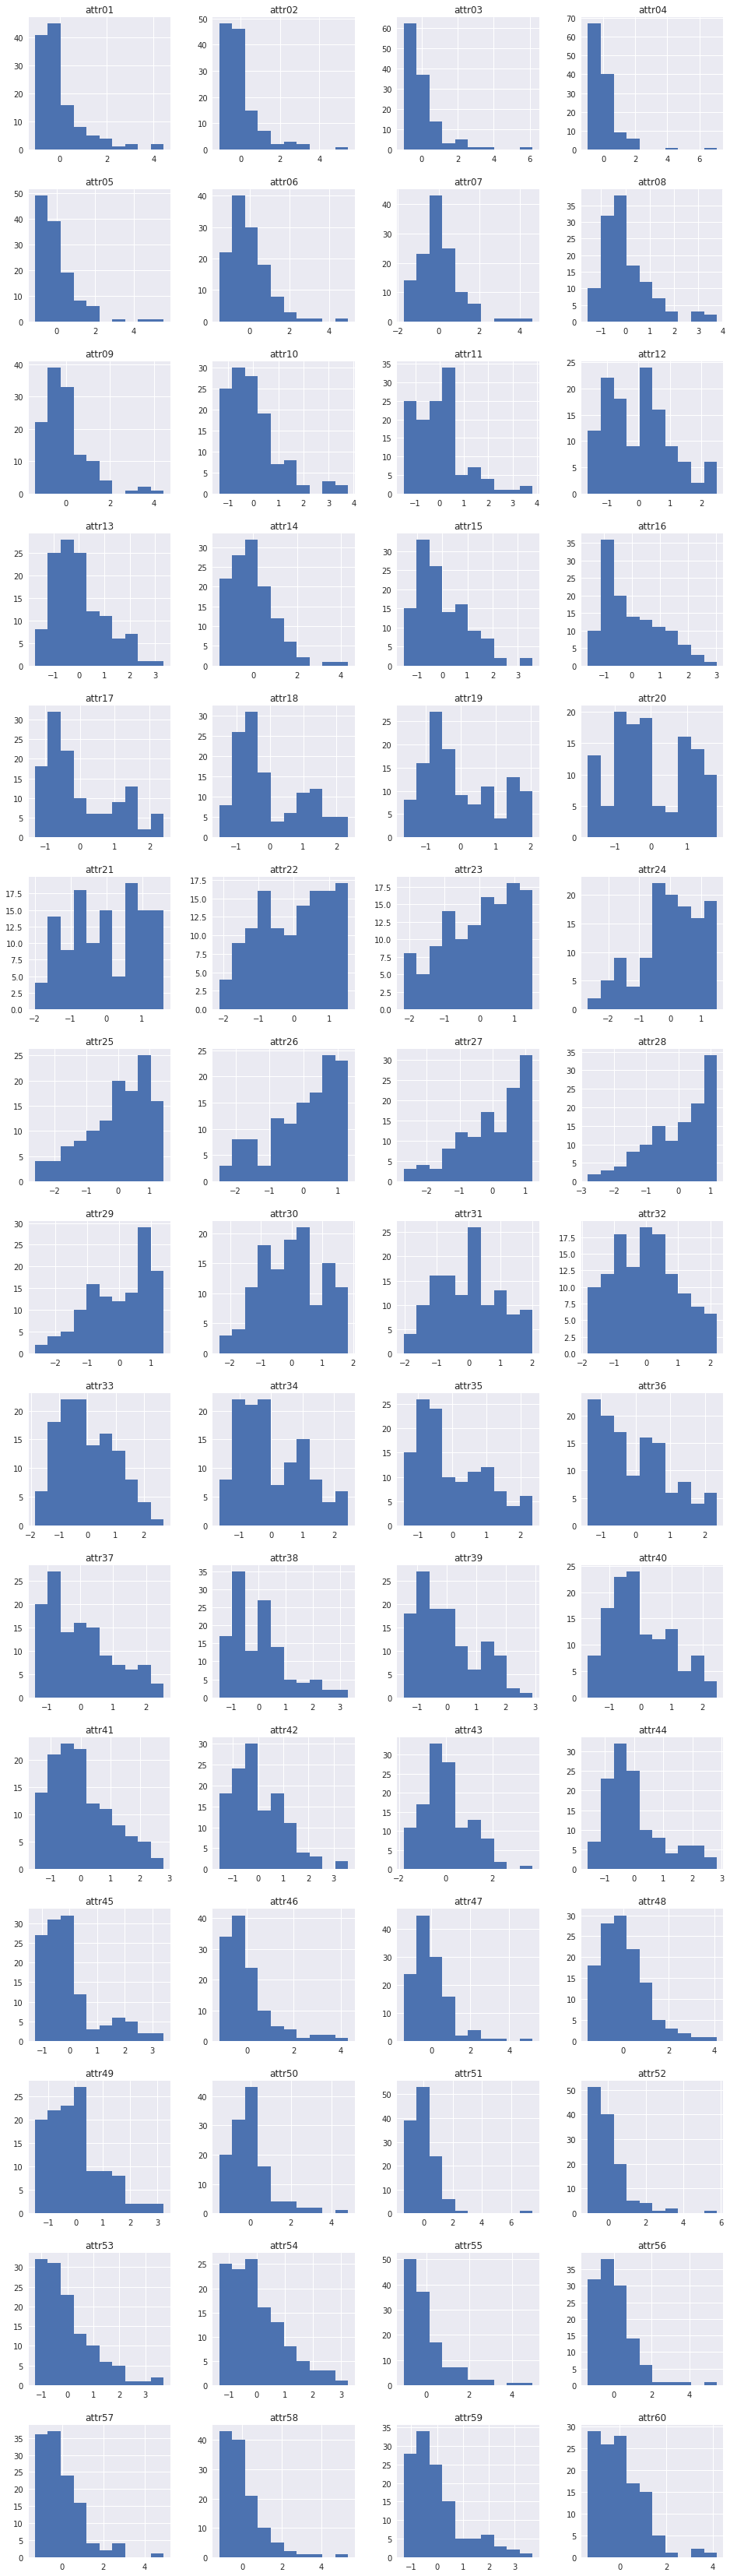

In [38]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [39]:
# Apply feature scaling and transformation to the validation dataset
scaled_features = scaler.transform(X_validation_df[columns_to_scale])
X_validation_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_validation_df.head())

       attr01    attr02    attr03    attr04    attr05    attr06    attr07    attr08    attr09    attr10  ...    attr51    attr52  \
125 -0.265543  1.272659  1.308655 -0.249210  0.663087  1.173733  0.862345  1.058253  1.371107  1.116805  ...  0.034130  0.428945   
48  -0.421811 -1.028845  0.465579 -0.203291 -0.668016 -0.495261 -0.364475  0.222612 -0.859186 -1.240519  ... -1.136096 -0.357936   
173  0.149801 -0.526185 -0.137290  0.131541  0.732698  0.880226  1.667886  0.413219  0.705074  0.488037  ... -0.449798 -0.338015   
163 -0.907064 -1.059908 -0.836714 -0.951400 -0.520304 -0.191334  0.130836 -0.351733  0.219735  0.224624  ... -0.555382 -0.507343   
204  0.125127 -0.850937 -0.344527  0.011002  0.056960 -0.029818 -0.207597 -0.327749 -0.606041  0.102590  ... -0.916128 -0.676672   

       attr53    attr54    attr55    attr56    attr57    attr58    attr59    attr60  
125  1.112464  2.104977  0.711167  0.753708  0.696220  0.175465 -1.110348 -0.626375  
48   0.160126  0.066749  0.075552  

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
# # Compose pipeline for the numerical and categorical features (Block #1 of 2)
# numeric_columns = X_train_df.select_dtypes(include=['int64','float64']).columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler())
# ])
# categorical_columns = X_train_df.select_dtypes(include=['object','bool']).columns
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
#     ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# print("Number of numerical columns:", len(numeric_columns))
# print("Number of categorical columns:", len(categorical_columns))
# print("Total number of columns in the dataframe:", X_train_df.shape[1])

In [41]:
# # Compose pipeline for the numerical and categorical features (Block #2 of 2)
# preprocessor = ColumnTransformer(transformers=[
#     ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
# ])

# # Display the shapes of the training datasets for final inspection
# X_train = preprocessor.fit_transform(X_train_df)
# y_train = y_train_df.ravel()
# print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

In [42]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train['new_feature1'] = feature_binned
# X_train['new_feature1'] = X_train['new_feature1'].astype('category')
# X_train.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train.head()

### 3.c) Training Data Balancing

In [43]:
# Not applicable for this iteration of the project

In [44]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [45]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=seedNum)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.d) Feature Selection

In [46]:
# Not applicable for this iteration of the project

In [47]:
# Find collinear features (Block #1 of 3)

# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [48]:
# Find collinear features (Block #2 of 3)

# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = X_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [49]:
# Find collinear features (Block #3 of 3)

# Drop the highly collinear features
# X_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [50]:
# Perform Attribute Importance Ranking (Block #1 of 3)

# Feature Importance with Gradient Boosting Classifier
# X_impVal = X_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(X_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = X_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [51]:
# Perform Attribute Importance Ranking (Block #2 of 3)

# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [52]:
# Perform Attribute Importance Ranking (Block #3 of 3)

# Removing the unselected attributes from the training and validation dataframes
# X_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [53]:
# Perform Recursive Feature Elimination (Block #1 of 3)

# Using the ensemlbed tree algorithm, we perform the Recursive Feature Elimination (RFE) technique
# X_rfeVal = X_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estFunc = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
# strFold = StratifiedKFold(n_splits=num_folds, random_state=seedNum)
# minFeatures = 10
# selector = RFECV(estimator=estFunc, step=1, min_features_to_select= minFeatures, cv=strFold, scoring=scoring)
# selector = selector.fit(X_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The ranking of selected features:\n',selector.ranking_)
# plt.figure(figsize=(16,12))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(minFeatures, len(selector.grid_scores_) + minFeatures), selector.grid_scores_)
# plt.show()

In [54]:
# Perform Recursive Feature Elimination (Block #2 of 3)

# Remove the unselected attributes from the training dataframes
# X_train_df = X_train_df[X_train_df.columns[selector.support_]]
# print(X_train_df.shape)
# X_train_df.head()

In [55]:
# Perform Recursive Feature Elimination (Block #3 of 3)

# Remove the unselected attributes from the validation dataframes
# X_test_df = X_test_df[X_test_df.columns[selector.support_]]
# print(X_test_df.shape)
# X_test_df.head()

### 3.e) Display the Final Datasets for Model-Building

In [56]:
# Finalize the training and validation datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.ravel()
X_validation = X_validation_df.to_numpy()
y_validation = y_validation_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (124, 60) y_train.shape: (124,)
X_validation.shape: (42, 60) y_validation.shape: (42,)


In [57]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [58]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [59]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))

In [60]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGR: 0.822000 (0.084000)
LogisticRegression(random_state=888)
Model training time: 0:00:00.128991 

CART: 0.678000 (0.064622)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.045585 

KNN: 0.798333 (0.050706)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:00.051754 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.759000 (0.065146)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:00.446776 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.798333 (0.035932)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:02.683780 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


EXT: 0.822667 (0.059569)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:01.892121 

GBM: 0.774667 (0.073078)
GradientBoostingClassifier(random_state=888)
Model training time: 0:00:02.072803 

Average metrics (accuracy) from all models: 0.7789999999999999
Total training time for all models: 0:00:07.446365


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


### 4.b) Spot-checking baseline algorithms

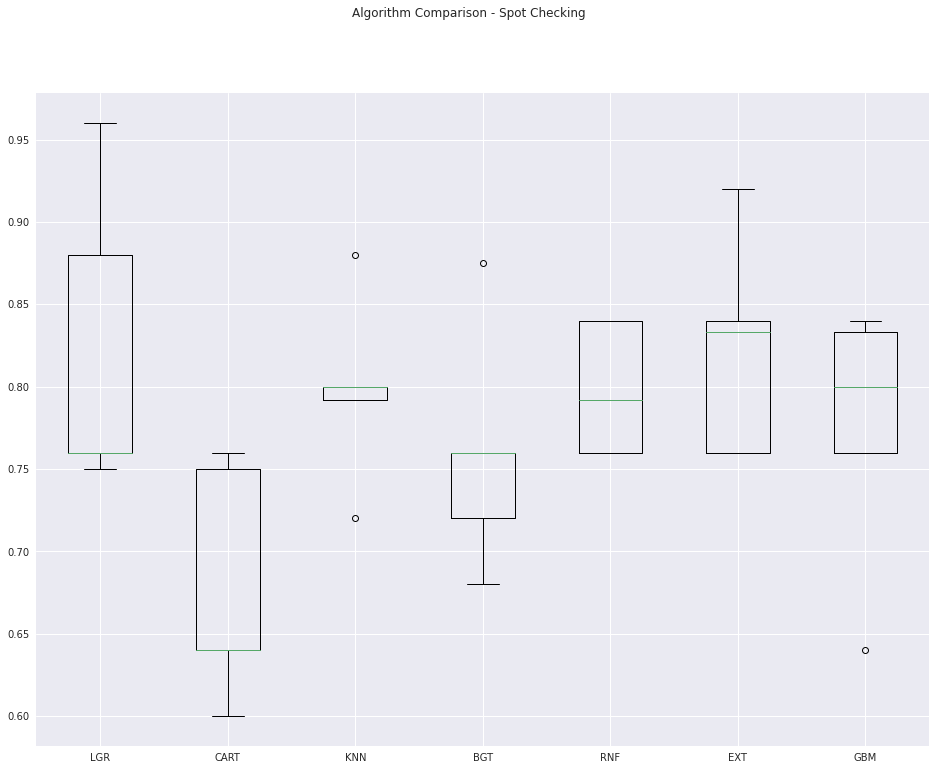

In [61]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [62]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [63]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [64]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [65]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([10, 50, 100, 150, 200]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.855000 using {'n_estimators': 50}
0.815000 (0.064031) with: {'n_estimators': 10}
0.855000 (0.031305) with: {'n_estimators': 50}
0.822667 (0.059569) with: {'n_estimators': 100}
0.839000 (0.055893) with: {'n_estimators': 150}
0.855000 (0.059498) with: {'n_estimators': 200}
Model training time: 0:00:09.856960


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.7s finished


In [66]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 50


In [67]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([50, 100, 150, 200, 250]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   20.1s finished


Best: 0.814333 using {'n_estimators': 200}
0.806000 (0.048826) with: {'n_estimators': 50}
0.798333 (0.035932) with: {'n_estimators': 100}
0.814333 (0.054849) with: {'n_estimators': 150}
0.814333 (0.041575) with: {'n_estimators': 200}
0.806333 (0.053421) with: {'n_estimators': 250}
Model training time: 0:00:21.125473


In [68]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 200


### 5.b) Compare Algorithms After Tuning

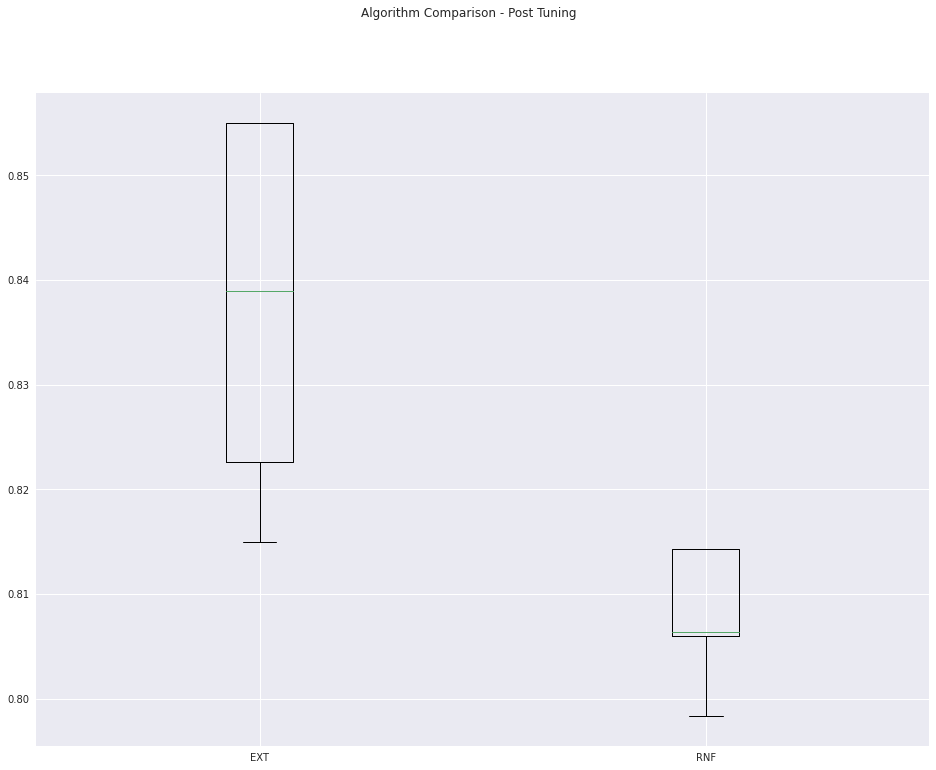

In [69]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [70]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [71]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Validate the models using the validation dataset

In [72]:
validation_model1 = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
validation_model1.fit(X_train, y_train)
print(validation_model1)
predictions1 = validation_model1.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_validation, predictions1))
print(confusion_matrix(y_validation, predictions1))
print(classification_report(y_validation, predictions1))

ExtraTreesClassifier(n_estimators=50, n_jobs=1, random_state=888)
Accuracy Score: 0.7619047619047619
ROC/AUC Score: 0.7643020594965675
[[15  4]
 [ 6 17]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        19
           1       0.81      0.74      0.77        23

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.77      0.76      0.76        42



In [73]:
validation_model2 = RandomForestClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
validation_model2.fit(X_train, y_train)
print(validation_model2)
predictions2 = validation_model2.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions2))
print('ROC/AUC Score:', roc_auc_score(y_validation, predictions2))
print(confusion_matrix(y_validation, predictions2))
print(classification_report(y_validation, predictions2))

RandomForestClassifier(n_estimators=200, n_jobs=1, random_state=888)
Accuracy Score: 0.8571428571428571
ROC/AUC Score: 0.851258581235698
[[15  4]
 [ 2 21]]
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.84      0.91      0.87        23

    accuracy                           0.86        42
   macro avg       0.86      0.85      0.85        42
weighted avg       0.86      0.86      0.86        42



### 6.b) Create a test model using all available data

In [74]:
# Combining the training and validation datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_validation))
y_complete = np.concatenate((y_train, y_validation))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
test_model = validation_model2.fit(X_complete, y_complete)
print(test_model)

X_complete.shape: (166, 60) y_complete.shape: (166,)
RandomForestClassifier(n_estimators=200, n_jobs=1, random_state=888)


### 6.c) Load test dataset and measure predictions

In [75]:
# Apply feature scaling and transformation to the test dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

       attr01    attr02    attr03    attr04    attr05    attr06    attr07    attr08    attr09    attr10  ...    attr51    attr52  \
8   -0.286104 -0.077180  0.093496 -0.159284 -0.134896 -0.667197 -0.625351 -1.489063 -0.908069 -0.393727  ... -0.828142  0.160011   
185  0.195036  0.628803 -0.149065 -0.576389 -0.484650  0.090016  0.315916  0.722482  0.805459  1.563268  ...  1.529908  0.120169   
60  -0.668550 -1.119211 -0.839068 -0.195637 -0.342032 -0.342429 -0.311595 -0.424946 -0.011587 -0.396704  ... -0.555382 -0.507343   
94  -1.100343 -0.263559 -0.643607 -0.631875 -0.496534  0.432151  1.479280  0.483908 -0.310996 -0.436141  ... -0.414603  0.199853   
22  -0.796031  0.230629 -0.342172 -0.499856 -0.126407  0.176852  2.212552  1.397811 -1.439673 -0.099806  ...  2.119421  0.438905   

       attr53    attr54    attr55    attr56    attr57    attr58    attr59    attr60  
8    0.290583  0.521219 -0.421886 -0.574193 -0.207494  0.175465 -0.310656 -0.970921  
185 -1.131402 -0.552983  0.144640 -

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
# Finalize the test dataset for the modeling testing
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (42, 60) y_test.shape: (42,)


In [77]:
test_predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

Accuracy Score: 0.6904761904761905
ROC/AUC Score: 0.675
[[ 7 13]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        20
           1       0.63      1.00      0.77        22

    accuracy                           0.69        42
   macro avg       0.81      0.68      0.65        42
weighted avg       0.81      0.69      0.65        42



In [78]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [79]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:02:13.281259
